# FHIR-Aggregator survival anaysis

In this notebook we will show how to retrieve data from breast cancer patients in TCGA and compare the Kaplan-Meier curves of two cohorts.
The cohorts are white and african american pateints that are 50 years or younger.

## Install necessay packages

In [ ]:
!pip install lifelines -q

In [ ]:
pip install git+https://github.com/FHIR-Aggregator/fhir-query.git

## Use FHIR-Aggregator to retrieve the necessary data

### Retrieve a pre-defined set of queries, a GraphDefinition

In [ ]:
!wget https://raw.githubusercontent.com/FHIR-Aggregator/fhir-query/refs/heads/main/graph-definitions/R5/ResearchStudyGraph.yaml

--2025-03-05 06:05:15--  https://raw.githubusercontent.com/FHIR-Aggregator/fhir-query/refs/heads/main/graph-definitions/R5/ResearchStudyGraph.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1840 (1.8K) [text/plain]
Saving to: ‘ResearchStudyGraph.yaml’

ResearchStudyGraph. 100%[===================>]   1.80K  --.-KB/s    in 0s      

2025-03-05 06:05:15 (33.1 MB/s) - ‘ResearchStudyGraph.yaml’ saved [1840/1840]



### Export TCGA-BRCA data to a local database

In [ ]:
%env  FHIR_BASE=https://google-fhir.test-fhir-aggregator.org
# export a study using a set of stored queries
!fq --fhir-base-url $FHIR_BASE  --graph-definition-file-path  ResearchStudyGraph.yaml  --path '/ResearchStudy?identifier=TCGA-BRCA'

env: FHIR_BASE=https://google-fhir.test-fhir-aggregator.org
research-study-graph is valid FHIR R5 GraphDefinition
ℹ Fetching https://google-fhir.test-fhir-aggregator.org/ResearchStudy?identifier=TCGA-BRCA
ℹ Processing ResearchStudy with 1 resources
ℹ Processing 11 links for ResearchStudy in parallel.
ℹ Processing link: ResearchSubject/study={path} with 1 ResearchStudy(s)
ℹ Processing link: Group/part-of-study={path}&_count=1000&_total=accurate with 1 ResearchStudy(s)
ℹ Processing link: Patient/part-of-study={path}&_count=1000&_total=accurate with 1 ResearchStudy(s)
ℹ Processing link: Specimen/part-of-study={path}&_count=1000&_total=accurate with 1 ResearchStudy(s)
ℹ Processing link: Observation/part-of-study={path}&_count=1000&_total=accurate with 1 ResearchStudy(s)
ℹ Processing link: Procedure/part-of-study={path}&_count=1000&_total=accurate with 1 ResearchStudy(s)
ℹ Processing link: DocumentReference/part-of-study={path}&_count=1000&_total=accurate with 1 ResearchStudy(s)
ℹ Processin

### Create a tsv file from the extracted data

In [ ]:
!fq dataframe

Saved /tmp/fhir-graph.tsv


## Surviving analysis

After retrieveing the data, we then use the python library lifelines to plor Kaplan-Meier plots of two groups (white and african american) of Breat cancer patients that are 50 years old or younger.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()


# read the data into a dataframe
df = pd.read_csv('/tmp/fhir-graph.tsv')

# get days to death data in the necessary formay
df['days_to_death'] = (
    df['patient_observation_days_between_diagnosis_and_death']
    .str.replace(' days', '', regex=False)
    .replace('', np.nan)
    .astype(float)
)
# get age data in the necessary format
df['age_at_diagnosis'] = (
    df['patient_observation_days_between_birth_and_diagnosis']
    .str.replace(' days', '', regex=False)
    .replace('', np.nan)
    .astype(float)
)

# group by patient_id
df_unique = df.drop_duplicates(subset=['patient_id'])

<ipython-input-6-82172718ba18>:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/tmp/fhir-graph.tsv')


Select Breast cancer patients that are white, african american, and 50 years old or younger.

In [ ]:
df_cohort = df_unique[ (df_unique['age_at_diagnosis'] >= -50*365 )
                      & (df_unique['patient_us_core_race'].isin(['black or african american','white']) )
                      & (df_unique['patient_us_core_ethnicity'] == 'not hispanic or latino')   ]


Get the necessary data for [`lifelines` package](lifelines.readthedocs.io).

In [ ]:
# Fill in NAs in days_to_death with the max from the days to death
T = df_cohort['days_to_death'].fillna(df_cohort['days_to_death'].max())

# Convert the vital status to numbers
E = df_cohort['patient_deceasedBoolean'].astype(bool)

Plot the survivial curves

Text(0.5, 0, 'Days')

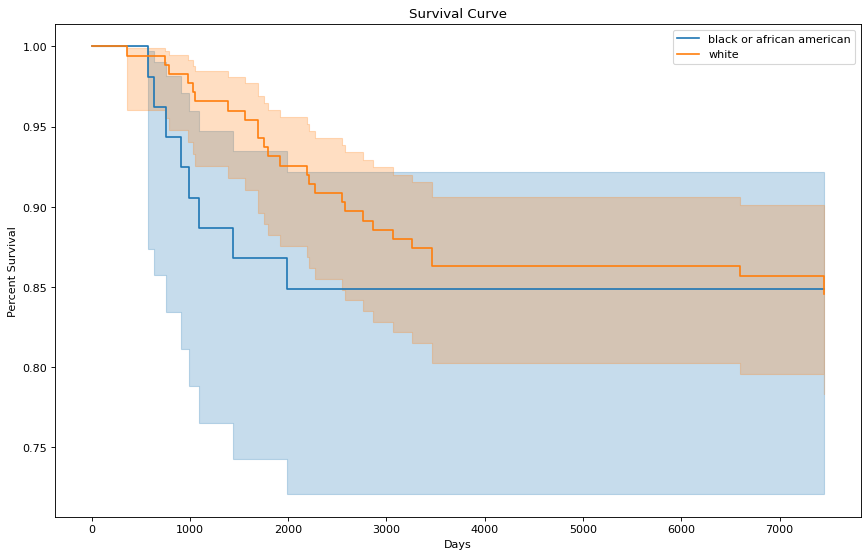

In [ ]:

fig=plt.figure(figsize=(13, 8), dpi= 80)
#plt.style.use('seaborn-colorblind')
ax = plt.subplot(111,
                 title = "Survival Curve")

for r in  df_cohort['patient_us_core_race'].sort_values().unique() :
  if (r != None):
    cohort = df_cohort['patient_us_core_race'] == r
    kmf.fit(T.loc[cohort], E.loc[cohort], label=r)
    kmf.plot(ax=ax, )
  else:
    print("")

ax.set_ylabel("Percent Survival")
ax.set_xlabel("Days")